In [1]:
import torch

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from transformers import BertTokenizer, BertModel
from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset
from torchtext.datasets import AG_NEWS

from tqdm import tqdm

from bert import EncodedDataset

/usr/venv/545bert/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cpu")

batch_size = 16
num_epochs = 64
max_len = 64
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

test_iter = AG_NEWS(split='test')
testset = to_map_style_dataset(test_iter)
testset = EncodedDataset(testset[:500], tokenizer, max_len, device)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

print(f"train set loaded - test: {len(testset)}")


train set loaded - test: 500


/usr/venv/545bert/lib/python3.8/site-packages/torch/utils/data/datapipes/utils/common.py:24: UserWarning: Lambda function is not supported for pickle, please use regular python function or functools.partial instead.
  warnings.warn(


In [3]:
class Classifier_model(nn.Module):
    def __init__(self):
        super().__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.embedding = self.bert.embeddings
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(768, 10) # 768 x 10
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(10, 4)
        self.softmax = nn.Softmax(1)

    def forward(self, inbatch):
        output = self.bert(inbatch['ids'], attention_mask=inbatch['mask'], token_type_ids=inbatch['token_type_ids'])
        output = output.pooler_output
        output = self.dropout(output)
        output = self.fc1(output)
        output = self.relu(output)
        output = self.fc2(output)

        return output
    
    def forward2(self,data, attention_mask):
        output = self.bert.encoder(data, attention_mask=attention_mask)
        print(output.hidden_states[0])
        print(output.hidden_states[0].shape)
        output = self.bert.pooler(hidden_states=output.hidden_states[0])

        output = self.dropout(output)
        output = self.fc1(output)
        output = self.relu(output)
        output = self.fc2(output)
        output = self.softmax(output)
        return output
    
    def forward_noemb(self, emb_data, mask):
        output = self.bert.forward(inputs_embeds=emb_data, attention_mask=mask)
        output = output.pooler_output
        output = self.dropout(output)
        output = self.fc1(output)
        output = self.relu(output)
        output = self.fc2(output)
        #output = self.softmax(output)
        return output

In [4]:
model = torch.load('saved_bert', map_location=torch.device('cpu'))
# for name, param in model.named_parameters():
#     param.requires_grad = True

In [5]:
def evaluate_topk(model, dataloader, topk=1):
    model.eval()
    total_acc, total_count = 0, 0
    with torch.no_grad():
        for idx, data in tqdm(enumerate(dataloader)):
            label = data['targets'] - torch.ones(data['targets'].shape, dtype=torch.long)
            emb_x = model.bert.embeddings.forward(data['ids'], token_type_ids=data['token_type_ids'])
            predicted_label = F.softmax(model.forward_noemb(emb_x, mask=data['mask']), dim=1)
            top_preds, top_idx = predicted_label.topk(k=topk, dim=1)
            for i, k in enumerate(top_idx):
                total_acc += int(label[i] in k)
            total_count += label.size(0)
    return total_acc/total_count

In [6]:
evaluate_topk(model, testloader, topk=1)

32it [00:27,  1.15it/s]


0.814

In [7]:
idx2label = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tec'}

In [8]:
def compute_text_saliency_map(X, mask, y, model):

    for param in model.parameters():
        param.requires_grad = False
    
    model.eval()
    
    X_var = Variable(X, requires_grad=True)
    y_var = Variable(y)

    scores = F.softmax(model.forward_noemb(emb_data=X_var, mask=mask), dim=1)
    grad_scores = scores[0, y.item()]
    grad_scores.backward()

    
    images_grads = X_var.grad.data[0]
    abs_text_grads = images_grads.abs()
    saliency = abs_text_grads.norm(p=2, dim=1) # can be max, or mean, or norm with any p. euclidean norm for p =2
    saliency = (saliency-saliency.min())/(saliency.max()-saliency.min())

    return saliency

In [9]:
def show_text_saliency_maps(X, y, tokenizer, correct_label, label_dict, model):

    X_emb = model.bert.embeddings.forward(X['ids'], token_type_ids=X['token_type_ids'])

    predicted_class = F.softmax(model(X), dim=1).argmax()
    
    print(f'The predicted class is: {label_dict[predicted_class.item()]}, the correct class is: {correct_label}')
    y_tensor = torch.LongTensor(y)
    saliencies = np.zeros(shape = (X['ids'].shape[1], *y.size())) # TODO check if first dim should be X['ids'].shape[1]
    
    for i, label in enumerate(y):
        saliencies[:, i] = compute_text_saliency_map(X_emb, mask=X['mask'], y=label, model=model).numpy() 
        
    detoked = np.array(tokenizer.decode(X['ids'].flatten()).split())

    N = y.size()[0]
    pad_idx = np.min(np.where(detoked == '[SEP]')[0])
    x_ticks = np.arange(pad_idx+1)
    fig, axes = plt.subplots(N, 1, sharex=False, sharey=False, figsize=(8,60))
    for i, label in enumerate(y):
        axes[i].plot(saliencies[:pad_idx+1, i], x_ticks, '-o')
        # axes[i].set_xticklabels(np.linspace(start=0, stop=saliencies[:, i].max(), num=10))
        axes[i].set_yticks(ticks=x_ticks, labels=detoked[:pad_idx+1])
        axes[i].set_title(f'class \'{label_dict[label.item()]}\' prediction')
        axes[i].grid()
        axes[i].invert_yaxis()
    plt.show()

In [10]:
n = np.random.randint(low=0, high=len(testset))
test_point = testset[n]

The predicted class is: Business, the correct class is: Business


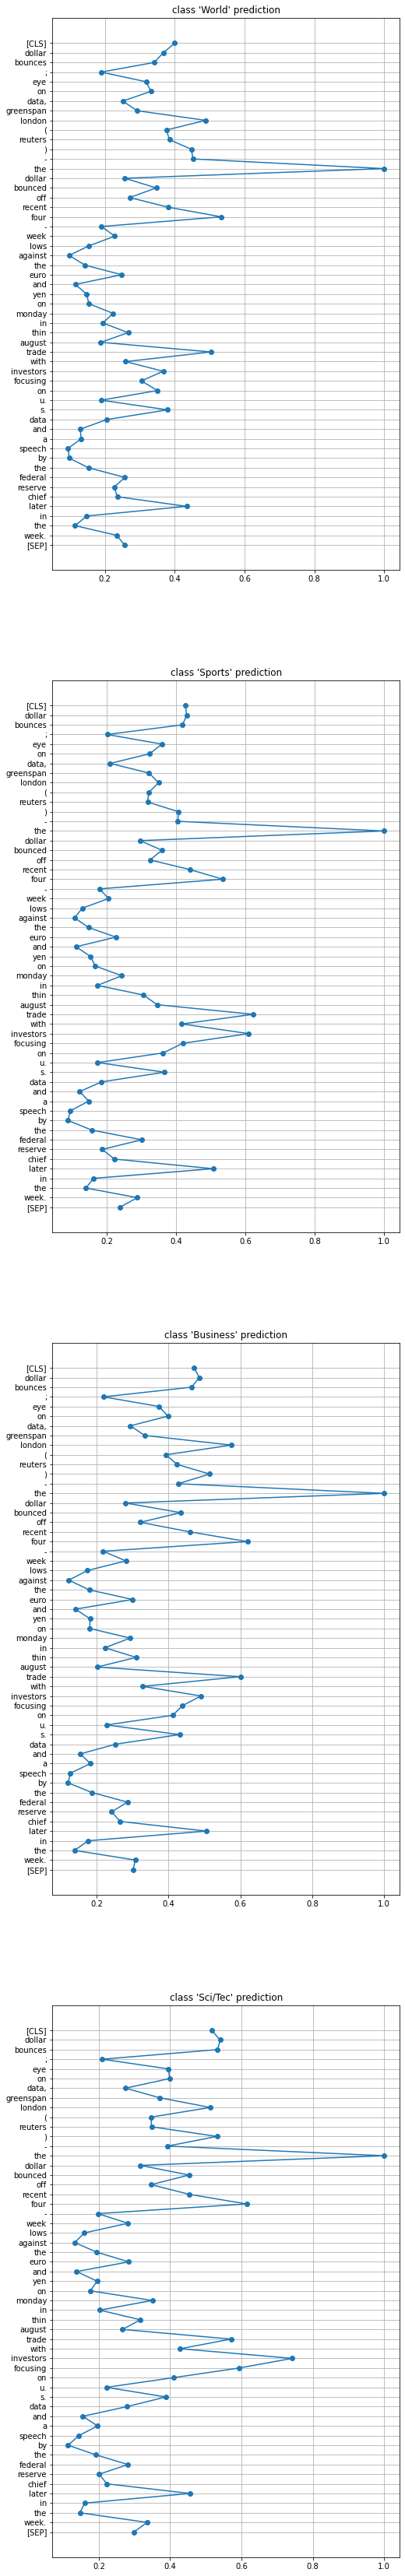

In [11]:
idx = test_point['targets'].item()-1
label = idx2label[idx]
for key in test_point:
    test_point[key] = torch.reshape(test_point[key], shape=(1,-1))

show_text_saliency_maps(test_point, torch.tensor([0, 1, 2, 3]), tokenizer, label, idx2label, model)